# Nikolay Ninov - Fleetcor Challenge

FleetCor offers multiple products. We would like to optimise the product x-sell campaign (selling Product B to customers who already purchased Product A). We would like you to tell us who are the customers that are most likely to buy into the B product, based on historical patterns.

You are thus provided with the file FleetCorChallenge.xlsx that contains the customers that buy the Product A – they can be identified as having a `null` AccountID.). The customers that purchased Product A and were targeted by cross-sell campaigns and identifiable by the Account Source = `cross-sell`. We also provide you the customers that buy the product A AND the product B – they can be identified as having a non-null AccountID, Account Source = `cross sell` and Product B Customer = `1`.

There are a number of questions below we would like you to answer with code and
explanations. As a business, we are interested in models that strike the right balance in terms of interpretability and performance. We are uncompromising on the need for ML models to have a business impact.

## Objectives:
- Build a model that predicts individual likelihood of a customer to buy into the Product B via a cross-sell campaign. How would you assess its performance
at this stage? What are the most important features in your model? How would
you communicate your findings to the business?
- How would you use this model – how would it bring value to the business?
- In your choosen scenario on how to use to model, how would you set up an
experiment to control the outcomes of the new process?
- Please explain the process you are suggesting, highlight the assumptions, and
discuss limitations that can potentially bring unexpected/unwanted results.

# Product cross-sell campaign optimisation 🤑

Before we dive into the coding part, the Jupyter notebook will be split in the following way:

1. **Exploratory Data Analysis** - this section will explore the provided dataset's features, ask and answer questions from the dataset. In this part the data itself will not be preprocessed unless it is required for visualization.

2. **Data Preparation** - this section will deal with preparing the dataset to be given to the model. Example problems that might occur are dealing with NaN values, curse of dimensionality, duplicates, scaling, etc.

3. **Machine Learning** - this section will take the preprocessed data from part 2, look into what would be the best way to measure the models' performance, insert different machine learning techniques and evaluate them.

In [ ]:
"""
This cell is used to import different libraries 
that will be used within the different sections
of the notebook.
"""

# Used in Exploratory Data Analysis and Data Preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random
# Used to balance the unbalanced dataset
from imblearn.over_sampling import SMOTE
from collections import Counter
# Used for data imputation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import math
# Used for data preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Used for visualizing missing data
import missingno as msno
# Access Google Drive
from google.colab import drive
# Used for model evaluation
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from mlxtend.plotting import plot_confusion_matrix
# Used for models
import xgboost as xgb
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
# Used to modify models' class weights
from sklearn.utils import class_weight

In [ ]:
# Access google drive
drive.mount('/content/drive')

In [ ]:
# Replace the path with your
path = "/content/drive/MyDrive/Colab Notebooks/Practice/Fleetcor/"
data = pd.read_excel(path+"FleetCorChallenge.xlsx")

## 1. Exploratory Data Analysis
This section will explore the provided dataset's features, ask and answer questions from the dataset. In this part the data itself will not be preprocessed unless it is required for visualization.

In [ ]:
# Load the head of the dataset to get an idea of the data
data.head()

In [ ]:
# Get information about the data's column types
data.info()

In [ ]:
# Get the dataset's size
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

### Missing data
In order for us to continue development we have to explore the missing data and if there are any connections. This will allow. us to make more accurate models and predictions.

In [ ]:
print(f"Missing data:\n\n{data.isna().sum()}")

The data is not missing values only in `Account Source` and `Total Fleet Size`. Missing values will be filled / removed in **2. Data Preprocessing**. However lets further explore the missing data. 

We will use the `missingno` library in order to quickly and easily visualize the missing data and how it is spread within the dataset. We will be using `missingno` barplot and dendogram in order for us to inspect any relations between missing data.

#### Barplot

A barplot will allow us to see how many values are missing for every column.

In [ ]:
msno.bar(data)
plt.show()

#### Dendogram

A dendogram allows us to see how the missing data is related with each other.

In [ ]:
msno.dendrogram(data)
plt.show()

#### Can we drop the NaN columns rather than imputing them?

There are two ways of dealing with missing data - either dropping all of the NaN columns or imputting data. The dataset is quite small and dropping the NaN rows could have a huge impact.

In [ ]:
total_rows = data.shape[0]
after_drop_rows = data.dropna().shape[0]

print("Rows before dropna:\t{}\n" .format(total_rows))
print("Rows after dropna:\t{} ({}%)" .format(after_drop_rows, round((after_drop_rows / total_rows) * 100)))

We will lose 95% of the dataset if we `dropna()` all of the NaN columns. We will have to impute the missing data in **2. Data Preprocessing**.

### Box plot
The boxplot will let us see the variability or dispersion of the data. It will give us information about how the values in the columns are distributed. We will be able to see if the data is symmetrical, how tight it is group and how it is skewed.

In [ ]:
types = ['int64', 'float64']

for type in types:
  for column in data.select_dtypes(include=[type]).columns:
    # Show box plot per column
    sns.boxplot(data = data[column])
    plt.title(f"{column} box plot")
    plt.ylabel(f"Values")
    plt.show()

    # Iteration separator
    print("=" * 48 + "\n")

Overall `Employees`, `Total Fleet Size` and `Credit Limit` have most of their values around 0 and have outliers. On the otherhand `Product B Customer` does not have any outliers - it only has `NaN` and `1` values. For `Credit Score` is the most different box plot and has most of its values are between 60 and 100.

In [ ]:
# Proof for no outliers in Product B Customer
data['Product B Customer'].unique()

### What unique values do object columns have?

Now we will dive a little bit deeper into knowing the values of the dataset to get an overall idea how the data can be preprocessed and given to the model(s). So far we have seen the numerical data but now we will explore the values for `object` columns.

In [ ]:
types = ['object']
# Print the unique column values for object columns
for type in types:
  for column in data.select_dtypes(include=[type]).columns:
    unique_values = data[column].unique()
    total = len(unique_values)
    # Check if there are more than 15 values
    if total > 15:
      # We do not want to print out all values because they could be too much
      unique_values = np.random.choice(unique_values, 15, p=[1 / len(unique_values) for i in range(len(unique_values))])
    
    # Print all values
    print(f"{column} has {total} unique values:\n{unique_values}")

    print("\n" + "=" * 100 + "\n")

### Data Hints

In this section we will explore the data based on the given hints within the challenge's description.

#### How many customers purchased Product A?

From the dataset we cannot clearly see how many customers have purchased Product A. However we know that they can be identified by having a `NaN` value in `AccountID`.

**Sentence hint**:

*You are thus provided with the file FleetCorChallenge.xlsx that contains the customers that buy the Product A – they can be identified as having a null AccountID.).*

In [ ]:
"""
We know that Total Fleet Size does not have 
any missing values. Hence we will use Total Fleet Size
to make the pandas queries smaller
"""
product_A = data.copy()

product_A['Product A'] = "Not purchased"
# NaN values in column AccountID indicate that Product A has been purchased
product_A.loc[product_A['AccountID'].isna(), 'Product A'] = "Purchased"

product_A = product_A.groupby("Product A").count().reset_index()[['Product A', 'Total Fleet Size']]
# Rename columns
renaming = {
  'Total Fleet Size': "Count",
  'Product A': 'Status',
}
product_A = product_A.rename(renaming, axis=1)

# Get the % of purchased and not purchased
total = product_A['Count'].sum()
product_A['Percent'] = (product_A['Count'] / total) * 100
product_A['Percent'] = product_A['Percent'].round(2)

product_A

In [ ]:
fig = px.histogram(product_A, x="Status", y="Percent", color = "Status", title="Distribution of Product A")
fig.update_layout(yaxis_title="Percent")
fig.show()

Overall majority (82.88%) of the customers have purchased Product A. This also indicates that 82.88% of the `AccountID`s are `NaN` values.

In [ ]:
# DataFrame product_A is not needed anymore
del product_A

#### What is the campaign distribution within customers who have purchased Product A?

82.88% of the total customers have purchased product A. Now we will explore how those customers were targeted by different campaigns.

**Sentence hint**:

*The customers that purchased Product A and were targeted by cross-sell campaigns and identifiable by the Account Source = ‘cross-sell’.*

In [ ]:
product_A = data.copy()

product_A['Product A'] = "Not purchased"
# NaN values in column AccountID indicate that Product A has been purchased
product_A.loc[product_A['AccountID'].isna(), 'Product A'] = "Purchased"

# We will just work with data which is Product A = Purchased
product_A = product_A.loc[product_A['AccountID'].isna()].copy()
product_A = product_A.groupby("Account Source").count().reset_index()[['Account Source', 'Product A']]

# Rename columns
renaming = {
  'Product A': "Count"
}
product_A = product_A.rename(renaming, axis=1)

# Get the % of purchased and not purchased
total = product_A['Count'].sum()
product_A['Percent'] = (product_A['Count'] / total) * 100
product_A['Percent'] = product_A['Percent'].round(2)

product_A

In [ ]:
fig = px.histogram(product_A, x="Account Source", y="Percent", color = "Account Source", title="Account Source distribution of customers who have purchased Product A")
fig.update_layout(yaxis_title="Percent")
fig.show()

19.55% of all customers who have purchased Product A were targeted by a cross-sell campaign.

In [ ]:
# DataFrame product_A is not needed anymore
del product_A

#### How many customers have purchased Product A and Product B?

We are told that there are customers who have bought both Product A and Product B. This somewhat gives us a clue to later further investigate customers who have bought Product B via a cross-sell campaign.

**Sentence hint**:

*We also provide you the customers that buy the product A AND the product B – they can be identified as having a non-null AccountID, Account Source = ‘cross sell’ and Product B Customer = 1.*

In [ ]:
both_products = data.copy()

# Create a column that will hold the customers who have purchased A and B
both_products['Status'] = "Not purchased"

query = np.logical_and(both_products['AccountID'].notnull(), # non-null AccountID
                       both_products['Account Source'].str.contains("Cross-sell")) # Account Source = 'cross sell' 

query = np.logical_and(query, both_products['Product B Customer'] == 1) # Product B Customer = 1
both_products.loc[query, 'Status'] = "Purchased"

both_products = both_products.groupby("Status").count().reset_index()[['Status', 'Total Fleet Size']]

# Rename columns
renaming = {
  'Total Fleet Size': "Count"
}

both_products = both_products.rename(renaming, axis=1)

both_products['Percent'] = (both_products['Count'] / both_products['Count'].sum()) * 100
both_products['Percent'] = both_products['Percent'].round(2)

both_products

In [ ]:
fig = px.histogram(both_products, x="Status", y="Percent", color = "Status", title="Customer distribution for purchasing both Product A and Product B")
fig.update_layout(yaxis_title="Percent")
fig.show()

Barely 5% of all customers have purchased Product A and Product B.

In [ ]:
# DataFrame both_products is not needed anymore
del both_products

### New Questions?

So far we explored the data based on the given information. Now we will further explore the data based on what we know so far.

#### How many people have purchased Product B?

We have seen how many people have purchased Product A and both products, however we do not know how many people have purchased Product B only.

In [ ]:
product_B = data.copy()

# NaN customers will be assumed that they have not purchased Product B
product_B.loc[product_B['Product B Customer'].isna(), 'Product B Customer'] = "Not purchased"
product_B.loc[product_B['Product B Customer'] == 1, 'Product B Customer'] = "Purchased"

product_B = product_B.groupby("Product B Customer").count().reset_index()[['Product B Customer', 'Total Fleet Size']]
# Rename columns
renaming = {
  'Total Fleet Size': "Count"
}

product_B = product_B.rename(renaming, axis=1)

product_B['Percent'] = (product_B['Count'] / product_B['Count'].sum()) * 100
product_B['Percent'] = product_B['Percent'].round(2)

product_B

In [ ]:
fig = px.histogram(product_B, x="Product B Customer", y = "Percent", color = "Product B Customer", title="Distribution of Product B")
fig.update_layout(yaxis_title="Percent")
fig.show()

Only 17.12% of all customers have bought Product B. However this is the complete opposite to clients who have not purchased Product A - 17.12%. However this cannot be true because there are clients which have purchased only Product A, only Product B and both Product A and B. Let's further investigate this.

In [ ]:
# DataFrame both_products is not needed anymore
del product_B

#### What is the distribution for clients who have purchased only Product A, only Product B and both Products A and B?

In [ ]:
purchases = data.copy()

# Store which product has the client purchased
purchases['Purchased'] = "Nothing"

# Change value of Purchased for clients who purchased ONLY Product A
purchases.loc[purchases['AccountID'].isna(), 'Purchased'] = "Product A"

# Change value of Purchased for clients who purchased ONLY Product B
purchases.loc[purchases['Product B Customer'] == 1, 'Purchased'] = "Product B"

# Change value of Purchased for clients who purchased BOTH Products A and B
query = np.logical_and(purchases['AccountID'].notnull(), # non-null AccountID
                       purchases['Account Source'].str.contains("Cross-sell")) # Account Source = 'cross sell' 

query = np.logical_and(query, purchases['Product B Customer'] == 1) # Product B Customer = 1
purchases.loc[query, 'Purchased'] = "Both"

distribution_purchases = purchases.groupby("Purchased").count().reset_index()[['Purchased', 'Total Fleet Size']]

# Rename columns
renaming = {
  'Total Fleet Size': "Count"
}

distribution_purchases = distribution_purchases.rename(renaming, axis=1)

distribution_purchases

In [ ]:
fig = px.pie(distribution_purchases, values="Count", names = "Purchased", labels={"Count": "Total"}, title = "Type of products purchased by customers")
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.show()

Majority of customers have purchased Product A. However **there are no customers that have not purchased a product**. Value `Nothing` in column Purchased is not seen in the pie chart which proves that all of the customers within the dataset have purchased something.

In [ ]:
# Get total number of people who have purchased Product B
product_B_purchases = distribution_purchases.iloc[0]["Count"] + distribution_purchases.iloc[2]["Count"]

# Represent the above number in %
percent = (product_B_purchases / distribution_purchases["Count"].sum()) * 100
percent = round(percent, 2)

print(f"{product_B_purchases} ({percent}%) customers have purchased Product B.")

#### How many customers purchased Product B via a cross-sell campaign?

Now that we have the correct numbers for customers who have purchased Product B, we can investigate how many of them actually purchased Product B through a cross-sell campaign. Our assumption is that it does not matter if a customer has purchased only Product B or both products. As long as it is either one, then Product B has been purchased regardless.

In [ ]:
product_B = purchases[["Account Source", "Purchased"]].copy()
# Fetch customers that have Purchased "both" or "Product B"
query = np.logical_or(product_B['Purchased'].str.contains("Product B"), product_B['Purchased'].str.contains("Both"))
query = np.logical_and(product_B['Account Source'].str.contains("Cross-sell"), query)

total_B = len(product_B)
cross_sell_B = len(product_B.loc[query])

print(f"Total customers:\t\t\t{total_B} (100%)\n")
print(f"Product B customers via Cross-sell:\t{cross_sell_B} ({round((cross_sell_B / total_B) * 100, 2)}%)\n")
print(f"Product B customers via Else:\t\t{total_B - cross_sell_B} ({round(((total_B - cross_sell_B) / total_B) * 100, 2)}%)")

Not even 5% of all Product B customers have purchased Product B. This makes the dataset highly unbalanced and will need further investigation. However we do not know if those 5% consist of customers who have purchased Product B, Both or a mixture of both.

In [ ]:
# The query here is the one from the cell above
print(f"Who was targeted via Cross-sell?\n\n{list(product_B.loc[query, 'Purchased'].unique())}")

In [ ]:
query = product_B['Purchased'].str.contains("Product B")
print(f"How were customers who purchased only Product B targeted?\n\n{list(product_B.loc[query, 'Account Source'].unique())}")

It seems that there are no customers who have purchased only Product B via Cross-sell. All the customers who have purchased Product B via Cross-sell have also purchased Product A.

#### Are there duplicate account numbers?

We have explored the different products and sourcing methods, however it is unknown if all of the `string` AccountIDs are unique or not. This will give us a better idea what to do with the AccountID column in the next section.

In [ ]:
# Remove NaN values and check if there are any duplicated customers
condition = data['AccountID'].dropna().duplicated().any()

if condition:
  print("There are duplicated customers.")
else:
  print("There are no duplicated customers.")

It turns out that there are duplicated account numbers which means that  the same customer has made multiple purchases.

#### Do duplicated customers from the same Industry?

We will further investigate this with the most duplicated AccountID.

In [ ]:
"""
Count number of occurrences for every AccountID.
We take the Total Fleet Size column as well because it does not have any NaN values.
This will give us an accurate number. of AccountID occurrences.
"""
accounts = data.groupby("AccountID").count().reset_index()[['AccountID', 'Total Fleet Size']]

# Rename columns
renaming = {
  'Total Fleet Size': "Occurrences"
}

accounts = accounts.rename(renaming, axis=1)

accounts.head()

In [ ]:
# Get most occurred AccountID
query = accounts['Occurrences'] == accounts['Occurrences'].max()
# We will get only the one of the most occurred number
index = accounts.loc[query].index[1]

print(f"There are {len(accounts.loc[query].index)} most occurring AccountIDs.\n")

most_occurred = accounts.iloc[index]
print(f"Account that will be further investigated:\n\n{most_occurred}")

In [ ]:
query = data['AccountID'].str.contains(most_occurred['AccountID'], na=False)

data.loc[query]

It is safe to assume that the transactions are similar to each other. However the Total Fleet size for index 1 is different. Even though there is no date column, we can safely assume that transactions come from a different date time.

## 2. Data Preparation

Before we give the data to the machine learning models, we have to find a way to prepare the data into numbers that can help us predict, in order to make predictions and make them as accurate as possible.

### What is the Target?

As mentioned in the description, we need to build a model that predicts individual likelihood of a customer to buy into the Product B via a cross-sell campaign. This prediction will require a new target column. We will pick up the dataframe from question "*What is the distribution for clients who have purchased only Product A, only Product B and both Products A and B?*"

In [ ]:
model_data = purchases.copy()
# Target column that the model will predict
model_data['Target'] = 0

# Fetch customers that have Purchased "Both" and "Product B"
query = np.logical_or(model_data['Purchased'].str.contains("Product B"), model_data['Purchased'].str.contains("Both"))
query = np.logical_and(model_data['Account Source'].str.contains("Cross-sell"), query)

# Customers who bought Product B via a cross-sell campaign
model_data.loc[query, 'Target'] = 1

# Store normal dataset
original_data = model_data.copy()

fig = px.histogram(model_data, x="Target", color = "Target", title="Customers who have purchased Product B via a cross-sell campaign")
fig.show()

As previously mentioned, barely 5% of the target values is 1 which makes the dataset highly unbalanced. After cleaning the `NaN` values from the dataset we will deal with this problem.

### Missing values

As we previously saw there are quite a lot of missing values. If we drop all of the `NaN` rows, we will have only 5% of the dataset remaining. This will not be enough for training. To make the `NaN` values. as accurate as possible, we will use `KNNImputer`.


For `KNNImputer` some of the missing columns are non numerical and they have to be edited in the following way:

1. Convert the `np.nan` values to string `'NaN'`. To make the data more consistent, we will make all str values lowercase.
2. Use `LabelEncoder` to encode target labels with values between `0` and `n_classes - 1`.
3. At this point the data is converted to numbers (including the `'NaN'` values). Now the they will be converted back to `np.nan`. The created dictionaries (`le_dictionary` and `dictionary`) will help us convert the data from numbers back to text data.

In [ ]:
# Get all NaN columns that are non numerical values
nan_columns = ['AccountID', 'Billing State/Province', 'Industry', 'Status']
model_data[nan_columns] = model_data[nan_columns].astype(str)

# Store the label encoders for every column
le_dictionary = {}
# Store the dictionary for every column
dictionary = {}

# Replace NaN values with String
for column in nan_columns:
  model_data.loc[model_data[column].isnull(), column] = 'NaN'
  # Make data lowercase
  model_data[column] = model_data[column].str.lower()

In [ ]:
for column in nan_columns:
  # Convert the data from string to numbers
  le = LabelEncoder()
  labels = model_data[column]
  encodings = le.fit_transform(model_data[column])
  # np.nan works with floats and we will have to change the int64 to float65
  encodings = encodings.astype(np.float64)
  # Create a dictionary in the format label: encoding
  column_dictionary = dict(zip(labels, encodings))
  
  # Iterate over every encoded value
  for i in range(len(encodings)):
    # Check if current value number is the NaN number
    if encodings[i] == column_dictionary['nan']:
      # Change the NaN number to np.nan so it can be given to KNNImputer
      encodings[i] = np.nan

  # Add label encoder to dictionary
  le_dictionary[column] = le
  # Add current column dictionary to dictionary
  dictionary[column] = column_dictionary
  # Update column
  model_data[column] = encodings

  print(f"Finished {column}!")

In [ ]:
non_nan_columns = model_data.drop(columns=model_data.columns[model_data.isna().any()].tolist()).columns.tolist()
non_nan_columns.pop()

for column in non_nan_columns:
  # Convert the data from string to numbers
  le = LabelEncoder()
  labels = model_data[column]
  encodings = le.fit_transform(model_data[column])
  encodings = encodings.astype(np.float64)
  # Create a dictionary in the format label: encoding
  column_dictionary = dict(zip(labels, encodings))

  # Add label encoder to dictionary
  le_dictionary[column] = le
  # Add current column dictionary to dictionary
  dictionary[column] = column_dictionary
  # Update column
  model_data[column] = encodings

  print(f"Finished {column}!")

In [ ]:
model_data.hist(figsize=(16, 18))
plt.plot()

The data does not follow a Gaussian distribution, which means we will use Normalization rather than Standardization. We will use Min-Max Scaling to converge the values between 0 and 1.

#### KNN Imputation

KNN for missing values approximates the closest values for the missing values, based on the closest points around the `np.nan` variables. In order for the correct value to be predicted we need to give a number of neighbours that `KNNImputer` will calculate the the missing values.

The `n_neighbors` indicates the count of the nearest neighbours that the algorithm will take into consideration for giving the `np.nan` values a number.

There are no pre-defined ways of getting the best value of K. Choosing a small number of `n_neighbors` can lead to noisy decisions, whereas large `n_neighbors` values could give better and smoother decisions (lower variance) but high bias.

Instead of try and failiure with `n_neighbors`, [we will choose the square root of N](https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/k-nearest-neighbor) (where N is the total number of data points in the training set) as our `n_neighbors` default value. I[n order to avoid algorithm confusions between different class selection we will make the `n_neighbors` value an odd number.](https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e)

In [ ]:
iknn_data = model_data.copy()

# Get the columns of the iknn_data before it is scaled down
iknn_columns = iknn_data.columns

scaler = MinMaxScaler()
iknn_data = scaler.fit_transform(iknn_data)

In [ ]:
knn_value = round(math.sqrt(iknn_data.shape[0]))

# If knn_value is even => make odd by incrementing it
if knn_value % 2 == 0:
  knn_value = knn_value + 1

print(f"Neighbours:\t{knn_value}")

In order not to wait for the long KNN Imputation the results have been saved to train_no_missing_data_iknn.csv to speed up the results. Feel free to uncomment the code if you would like to run the KNNImputer.

In [ ]:
"""
knn_imputer = KNNImputer(n_neighbors=knn_value)
new_iknn_data = knn_imputer.fit_transform(iknn_data)
# Scale up the data
new_iknn_data = scaler.inverse_transform(new_iknn_data)
# Convert to Pandas Dataframe
new_iknn_data = pd.DataFrame(data=new_iknn_data, columns=iknn_columns)
print("Missing values:\n\n{}" .format(new_iknn_data.isna().sum()))

# Save the iknn data to a csv file so it is faster to access
new_iknn_data.to_csv(path + "train_no_missing_data_iknn.csv", index=False)
"""

In [ ]:
# If you have uncommented the latter code cell, please comment out this code cell
new_iknn_data = pd.read_csv(path+"train_no_missing_data_iknn.csv")

Now the dataset does not have any missing values.


In [ ]:
print("Missing values in new_iknn_data:\n\n{}" .format(new_iknn_data.isna().sum()))

### Duplicates

Now that there is no missing data, we can handle duplicated data.

In [ ]:
model_data = new_iknn_data.copy()
del new_iknn_data

In [ ]:
print(f"Data before dropping duplicates:\t{len(model_data)}")
# Remove duplicates and reset indexes
model_data = model_data.drop_duplicates().reset_index(drop=True)
print(f"Data before dropping duplicates:\t{len(model_data)}")

In [ ]:
fig = px.histogram(model_data, x="Target", color = "Target", title="Target column after dropping Duplicates")
fig.show()

Around 5K data rows were dropped and **there was no impact on the customers who purchased Product B via a Cross-sell.**

### Column 

Some of the columns used to be string. They were values that were converted to `np.float64`. Now they will be converted back to `int` values.

We will also split the data into X and Y variables for the models.

In [ ]:
int_columns = ["AccountID", "Billing State/Province", "Account Source", "Employees", "Industry", "Product B Customer", "Status", "Purchased", "Target", "Total Fleet Size"]
model_data[int_columns] = model_data[int_columns].astype(int)
model_data[int_columns].head()

In [ ]:
X = model_data.drop(columns = ["Target"]).copy().to_numpy()
Y = model_data["Target"].copy().to_numpy()

### Data scaling

Currently the variables are measured at different scaled and do not equally contribute to the model's learning and even create a bias. We will scale down the values between 0 and 1 or -1 and 1 with `MinMaxScaler` which will be essential in algorithms such as MLP and KNN. However in tree-based algorithms such as Random Forest, Gradient Boost and XGBoost scaling is unnecessary.

In [ ]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

### SMOTE - Synthetic Minority Oversampling Technique

We will not use undersampling because that means that we will lose a big part of the dataset and models will underfit. On the other hand oversampling is more computationally expensive but no data is lost compared to undersampling. In both cases the data will be 50% customers who have purchased Product B via Cross-sell (`1`) and 50% customers who have not purchased Product B via Cross-sell (`0`).

**SMOTE** is another approach to handle imbalanced datasets. It evens out the minority class but without copying already existing data. This technique synthesises new minority data points between existing minority instances.

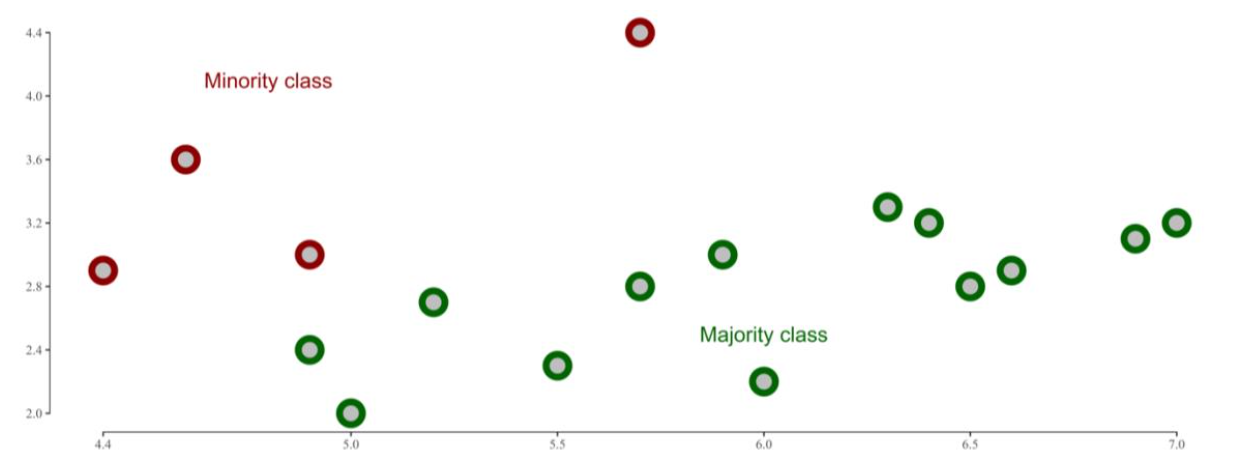

Initially the algorithm plots down every data point. Then the feature vector and the data point’s nearest neighbours are identified. The difference between the two vectors is calculated and their difference is multiplied by a random number between 0 and 1. Finally the new point is identified on the line segment by adding the random number to feature vector.

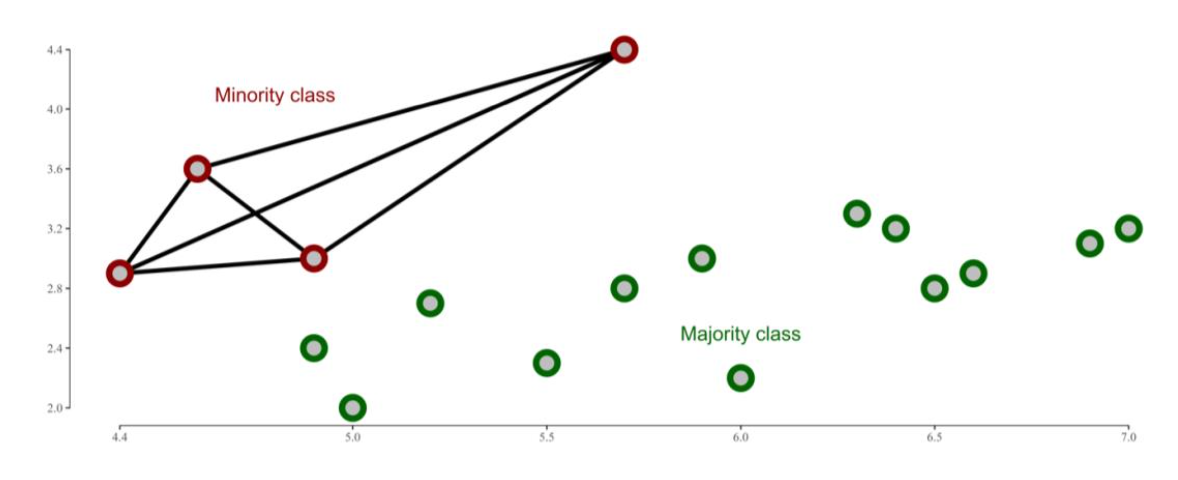

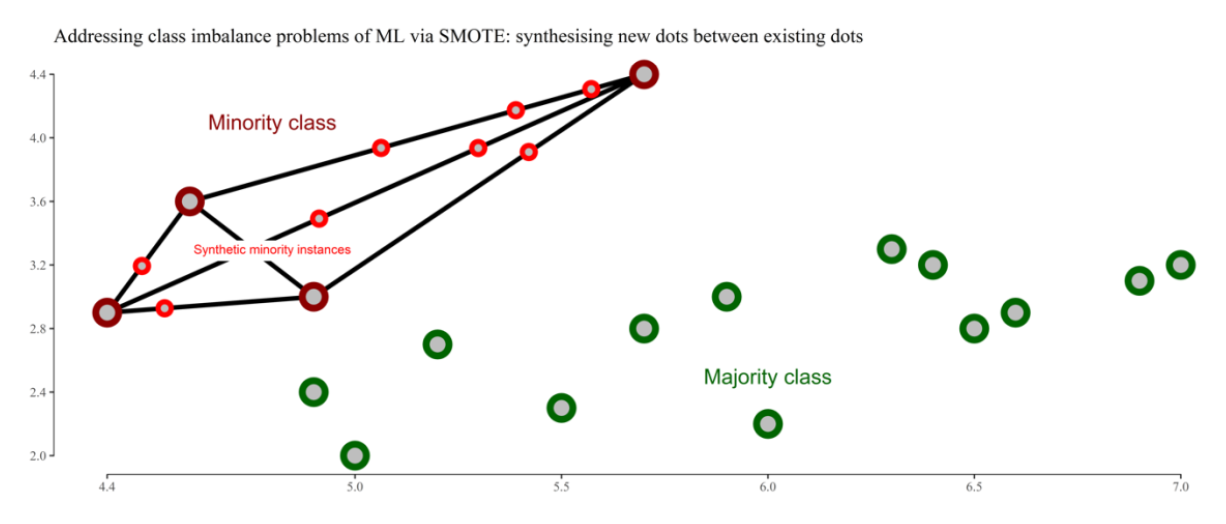

In [ ]:
# Create SMOTE data
oversample = SMOTE()
X_smote, Y_smote = oversample.fit_resample(X, Y)

print("Normal data:\t{}\n". format(Counter(Y)))
print("SMOTE data:\t{}". format(Counter(Y_smote)))

### Data splitting

The data will be split in the following way:

1. **train** (85%) - used to learn the parameters of the model.
2. **validate** (7.5%) - used to measure how accurately the model predicts data.
3. **test** (7.5%) - used as a proxy for unseen data and evaluate how the model is doing on the test set.

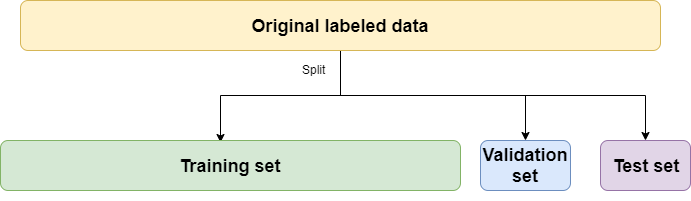

In [ ]:
# Get training data (85%)
X_train, X_remaining, Y_train , Y_remaining = train_test_split(X_smote, Y_smote, test_size = 0.15, random_state=42)
# Get validate data (7.5%) and test data (7.5%)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_remaining, Y_remaining, test_size = 0.5, random_state=42)

del X_remaining, Y_remaining

train_size = round((len(X_train) / len(X_smote)) * 100, 2)
validate_size = round((len(X_validate) / len(X_smote)) * 100,2 )
test_size = round((len(X_test) / len(X_smote)) * 100, 2)

print(f"Train:\t\t{len(X_train)} samples ({train_size}%)\n")
print(f"Validate:\t{len(X_validate)} samples ({validate_size}%)\n")
print(f"Test:\t\t{len(X_test)} samples ({test_size}%)")

### Class weights

We will also have a dataset with `NaN` values in case the above dataset is "fake" enough for the models to generate perfect results.

In [ ]:
# Get all NaN columns that are non numerical values
nan_columns = ['AccountID', 'Billing State/Province', 'Industry', 'Status']
original_data[nan_columns] = original_data[nan_columns].astype(str)

# Store the label encoders for every column
le_dictionary = {}
# Store the dictionary for every column
dictionary = {}

# Replace NaN values with String
for column in nan_columns:
  original_data.loc[original_data[column].isnull(), column] = 'NaN'
  # Make data lowercase
  original_data[column] = original_data[column].str.lower()

In [ ]:
for column in nan_columns:
  # Convert the data from string to numbers
  le = LabelEncoder()
  labels = original_data[column]
  encodings = le.fit_transform(original_data[column])
  # np.nan works with floats and we will have to change the int64 to float65
  encodings = encodings.astype(np.float64)
  # Create a dictionary in the format label: encoding
  column_dictionary = dict(zip(labels, encodings))
  
  # Iterate over every encoded value
  for i in range(len(encodings)):
    # Check if current value number is the NaN number
    if encodings[i] == column_dictionary['nan']:
      # Change the NaN number to np.nan so it can be given to KNNImputer
      encodings[i] = np.nan

  # Add label encoder to dictionary
  le_dictionary[column] = le
  # Add current column dictionary to dictionary
  dictionary[column] = column_dictionary
  # Update column
  original_data[column] = encodings

  print(f"Finished {column}!")

In [ ]:
non_nan_columns = original_data.drop(columns=original_data.columns[original_data.isna().any()].tolist()).columns.tolist()
non_nan_columns.pop()

for column in non_nan_columns:
  # Convert the data from string to numbers
  le = LabelEncoder()
  labels = model_data[column]
  encodings = le.fit_transform(original_data[column])
  encodings = encodings.astype(np.float64)
  # Create a dictionary in the format label: encoding
  column_dictionary = dict(zip(labels, encodings))

  # Add label encoder to dictionary
  le_dictionary[column] = le
  # Add current column dictionary to dictionary
  dictionary[column] = column_dictionary
  # Update column
  original_data[column] = encodings

  print(f"Finished {column}!")

In [ ]:
iknn_data = original_data.copy()

# Get the columns of the iknn_data before it is scaled down
iknn_columns = original_data.columns

scaler = MinMaxScaler()
iknn_data = scaler.fit_transform(iknn_data)

In [ ]:
knn_value = round(math.sqrt(iknn_data.shape[0]))

# If knn_value is even => make odd by incrementing it
if knn_value % 2 == 0:
  knn_value = knn_value + 1

print(f"Neighbours:\t{knn_value}")

In [ ]:
"""
knn_imputer = KNNImputer(n_neighbors=knn_value)
new_iknn_data = knn_imputer.fit_transform(iknn_data)
# Scale up the data
new_iknn_data = scaler.inverse_transform(new_iknn_data)
# Convert to Pandas Dataframe
new_iknn_data = pd.DataFrame(data=new_iknn_data, columns=iknn_columns)
print("Missing values:\n\n{}" .format(new_iknn_data.isna().sum()))

# Save the iknn data to a csv file so it is faster to access
new_iknn_data.to_csv(path + "train_original_no_missing_data_iknn.csv", index=False)
"""

In [ ]:
# If you have uncommented the latter code cell, please comment out this code cell
new_iknn_data = pd.read_csv(path+"train_original_no_missing_data_iknn.csv")

print("Missing values:\n\n{}" .format(new_iknn_data.isna().sum()))

In [ ]:
original_data = new_iknn_data.copy()

int_columns = ["AccountID", "Billing State/Province", "Account Source", "Employees", "Industry", "Product B Customer", "Status", "Purchased", "Target", "Total Fleet Size"]
original_data[int_columns] = original_data[int_columns].astype(int)
original_data[int_columns].head()

In [ ]:
# Split the data into X and Y and convert to numpy arrays
X = original_data.drop(columns=["Target"]).copy().to_numpy()
Y = original_data["Target"].copy().to_numpy()

In [ ]:
# Scale down data
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

In [ ]:
# Get training data (70%)
X_train_original, X_remaining, Y_train_original , Y_remaining = train_test_split(X, Y, test_size = 0.15, random_state=42)
# Get validate data (15%) and test data (15%)
X_validate_original, X_test_original, Y_validate_original, Y_test_original = train_test_split(X_remaining, Y_remaining, test_size = 0.5, random_state=42)

del X_remaining, Y_remaining

train_size = round((len(X_train_original) / len(X)) * 100, 2)
validate_size = round((len(X_validate_original) / len(X)) * 100,2 )
test_size = round((len(X_test_original) / len(X)) * 100, 2)

print(f"Train:\t\t{len(X_train_original)} samples ({train_size}%)\n")
print(f"Validate:\t{len(X_validate_original)} samples ({validate_size}%)\n")
print(f"Test:\t\t{len(X_test_original)} samples ({test_size}%)")

## 3. Machine Learning

This section takes the prepared data from section **2. Data Preparation** to look into what would be the best way to measure the models' performance, insert different machine learning techniques and evaluate them.

### Metrics

Before we get into model selection we will have to determine which metrics will be used to evaluate them. If the metrics are not good or consistent enough then the model's performance cannot be accurately measured.

#### Confusion Matrix

- **True Positive - TP** [ 0 ] [ 0 ] - How many customers were targeted by a Cross-sell campaign.

- **False Positive - FP** [ 0 ] [ 1 ] - How many customers were not targeted by a Cross-sell campaign but were predicted to be.

- **False Negative - FN** [ 1 ] [ 0 ] - How many patients were targeted by. a. Cross-sell campaign but were not predicted to be.

- **True Negative - TN** [ 1 ] [ 1 ] - How many customers were not targeted by. a Cross-sell campaign

**Precision** quantifies the number of positive class predictions that actually belong to the positive class and **Recall** quantifies the number of positive. class predictions made out of all positive examples. However we will not be using **Accuracy** because the dataset target values are imbalanced. This creates the **Accuracy Paradox**. Good performance on the minority class will be preferred over good performance on both classes.

**F1** provides a single score that balances both the concerns of precision and recall in one number. The closer the number is to 1, the better the prediction is.

In [ ]:
def get_metrics(truth, prediction):
  """
  Function description

  Get the F1 score

  parameters:
    - truth - the ground truth of the values. In this case it would be the real sales from the dataset
    - prediction - the model's predicted values. In this case it would be the predicted sales from the dataset

  output:
    - F1 score
    - Recall
    - Precision
  """
  f1 = f1_score(truth, prediction)
  recall = recall_score(truth, prediction)
  precision = precision_score(truth, prediction)

  return f1, recall, precision

### Base model selection

There are many different algorithms that can be used to solve the classification problem, however we need to find the most optimal ones. We will start off with looking at the basic algorithm, without any hyperparameter tuning. The aim is to quickly find a good starting point and continue investigating from there onwards. We will pick algorithms that have a better basic performance.

In [ ]:
def train(algorithms, data):
  """
  Function description

  Get the basic performance of the passed 
  algorithms on the training data

  Parameters:
    - algorithms - all the algorithms in the above dictionary format
    - data - all the dataset in a dictionary format
    
  Output:
    - trained_algorithms - dictionary with the passed algorithms which were trained on the data
    - results - pandas dataframe with models' performance
  """
  results = pd.DataFrame()

  # Store trained algorithms
  trained_algorithms = {}

  for name, model in algorithms.items():
    model.fit(data["train"]["X"], data["train"]["Y"])

    # Add fitted algorithm in dictionary
    trained_algorithms.update({name: model})

    # Predict train data
    predictions = model.predict(data["train"]["X"])
    f1, recall, precision = get_metrics(data["train"]["Y"], predictions)

    # Append row to pandas dataframe - results
    result = {}
    result['1. Algorithm'] = name
    result['2. F1'] = f1
    result['3. Precision'] = precision
    result['4. Recall'] = recall
    
    results = results.append(result, ignore_index=True)
    print(f"Completed - {name}")
  
  print("Finished training!")

  return trained_algorithms, results

In [ ]:
# Print out the confusion matrix, Recall, Percision, F1 score and ROC curve.
def show_report(Y, predictions, name):
  """
  Function description:
  Visualize the confusion matrix and ROC curve

  Parameters:
    - Y - real prediction
    - predictions - model's predicted Y value
    - name - model's name
  
  Output:
    - results - pandas dataframe with models' performance
  """

  # Get ROC data
  random_probs = [0 for i in range(len(Y))]
  p_fpr, p_tpr, _ = roc_curve(Y, random_probs)

  fpr, tpr, thresh = roc_curve(Y, predictions)

  # Plot ROC curves
  plt.plot(fpr, tpr, linestyle='--',color='orange')
  plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
  
  # Title
  plt.title(f'ROC curve ({name})', fontsize=20)
  # x label
  plt.xlabel('False Positive Rate')
  # y label
  plt.ylabel('True Positive rate')

  plt.show();

  # Get confusion matrix results
  results = confusion_matrix(Y, predictions)
  # True Positive
  TP = results[0][0]
  # False Positive
  FP = results[0][1]
  # False Negative
  FN = results[1][0]
  # True Negative
  TN = results[1][1]

  print("TP = {:<4}\t\t\tFP = {:<4}\n" .format(TP, FP))
  print("FN = {:<4}\t\t\tTN = {:<4}\n" .format(FN, TN))

  f1, recall, precision = get_metrics(Y, predictions)

  print("Recall = {}%\n" .format(round(recall, 2) * 100,))
  print("Precision = {}%\n" .format(round(precision, 2) * 100))
  print("F1 score = {}%\n" .format(round(f1, 2) * 100))

  print("=" * 100)

In [ ]:
def model_results(algorithms, X, Y):
  """
  Function description

  Get the performance of the passed 
  trained algorithms on the validation / test data

  Parameters:
    - algorithms - all the algorithms in the above dictionary format
    - X - data that will be given to the model to predict
    - Y - real predictions
    
  Output:
    - results - pandas dataframe with models' performance
  """
  results = pd.DataFrame()

  for name, model in algorithms.items():

    # Predict train data
    predictions = model.predict(X)
    f1, recall, precision = get_metrics(Y, predictions)

    # Append row to pandas dataframe - results
    result = {}
    result['1. Algorithm'] = name
    result['2. F1'] = f1
    result['3. Precision'] = precision
    result['4. Recall'] = recall
    
    results = results.append(result, ignore_index=True)
    
    show_report(Y, predictions, name)

  return results

#### SMOTE

In this section we will train the models with the SMOTE dataset and measure their performance.

In [ ]:
# Store algorithms in format - name: algorithm instance
algorithms = {
    "XGBoost": xgb.XGBRFClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "GaussianNB": GaussianNB(),
    "LogisticRegression": LogisticRegression(),
    "MLP": MLPClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": svm.SVC()
}

# Store the the datasets within a dictionary
data = {
    "train": {
        "X": X_train,
        "Y": Y_train
    },
    "validate": {
        "X": X_validate,
        "Y": Y_validate
    },
    "test": {
        "X": X_test,
        "Y": Y_test
    }
}

In [ ]:
trained_algorithms, train_results = train(algorithms, data)

train_results

So far all base models except GaussianNB have a 1 for F1, Precision and Recall. Before we test the model's performance on the validation data, to see how it is performing on unseen data, we will see the feature importance on XGBoost, RandomForest and GradientBoosting.

In [ ]:
# Loop through tree algorithms - XGBoost, Random Forest and Gradient Boosting
for name in train_results['1. Algorithm'][0:3]:
  # Create pandas dataframe with feature importances for every column
  feature_importance = pd.Series(trained_algorithms[f"{name}"].feature_importances_, index = model_data.drop(columns=["Target"]).copy().columns)
  # Sort values
  feature_importance = feature_importance.sort_values()
  # Show bar plot of importance
  feature_importance.plot(kind="barh", title=f"Feature Importance ({name})")
  plt.show()

All tree algorithms found the Purchased column to be useful. This was a feature engineered column which tells if the customer has purchased Product A, Product B or both. However Gradient Boosting did not find any other feature to be as important as the Purchased one.

Now we will test the model's performance on the validation data, to see how it is performing on unseen data.

In [ ]:
validate_results = model_results(trained_algorithms, data["validate"]["X"], data["validate"]["Y"])

In [ ]:
validate_results

It seems that the model has correctly learnt how to identify customers who have bought However this could also be also be because the data is "very fake" because most of it was imputed. We will further investigate the with the original dataset and class weights.

#### Class weights

In this section we will train the models with the imbalanced dataset and measure their performance. We will use algorithms that can naturally handle unbalanced data

In [ ]:
classes = np.unique(Y_train_original)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=Y_train_original)

# Display the weights for every class, when class_weight = 'balanced'
print(f"Not targeted by Cross-sell weight (0):\t{weights[0]}\n")
print(f"Targeted by Cross-sell weight (1):\t{weights[1]}")

# Make results into a dictionary - for models
class_weights = dict(zip(classes, weights))

In [ ]:
# Store algorithms in format - name: algorithm instance
algorithms = {
    "RandomForest": RandomForestClassifier(class_weight=class_weights),
    "XGBoost": xgb.XGBRFClassifier(scale_pos_weight=100),
    "LogisticRegression": LogisticRegression(class_weight=class_weights),
    "SVM": svm.SVC(class_weight=class_weights)
}

# Store the the datasets within a dictionary
data = {
    "train": {
        "X": X_train_original,
        "Y": Y_train_original
    },
    "validate": {
        "X": X_validate_original,
        "Y": Y_validate_original
    },
    "test": {
        "X": X_test_original,
        "Y": Y_test_original
    }
}

In [ ]:
trained_algorithms, train_results = train(algorithms, data)

train_results

In [ ]:
# Loop through tree algorithms - XGBoost, Random Forest and Gradient Boosting
for name in train_results['1. Algorithm'][0:2]:
  # Create pandas dataframe with feature importances for every column
  feature_importance = pd.Series(trained_algorithms[f"{name}"].feature_importances_, index = model_data.drop(columns=["Target"]).copy().columns)
  # Sort values
  feature_importance = feature_importance.sort_values()
  # Show bar plot of importance
  feature_importance.plot(kind="barh", title=f"Feature Importance ({name})")
  plt.show()

When running class weights `XGBoost` feature importance differs from `RandomForest` and all of the SMOTE algorithms. `XGBoost` class weight finds the account source to be more important than if the customer has purchased Product A, Product B or both.

In [ ]:
validate_results = model_results(trained_algorithms, data["validate"]["X"], data["validate"]["Y"])

In [ ]:
validate_results

Overall the models perform very well on both SMOTE and Class weight data. Due to the models' good performance we will skip searching for optimal hyperparameters and enssemble voting.

# Fleetcor Questions:

### What assumptions were made?

We assume that a customer could have purchased either Product B (by itself) or both Product A and Product B via a cross-sell campaign. Based on the given information in the task's objectives customers who bought Product B via Cross-sell have also bought Product A. To have a "less imbalanced" dataset we marked customers who have purchased either Product B or both (Product A and Product B) as `1` and everybody else as `0`.

### How would you assess its performance at this stage? What are the most important features in your model? 

To accurately assess the models' performance we will use the following 3 metrics:
- **Precision** - quantifies the number of positive class predictions that actually belong to the positive class

- **Recall** - quantifies the number of positive. class predictions made out of all positive examples.

- **F1** - provides a single score that balances both the concerns of **Precision** and **Recall** in one number. The closer the number is to 1, the better the prediction is.

However we will not be using **Accuracy** because the dataset target values are imbalanced. This creates the **Accuracy Paradox**. Good performance on the minority class will be preferred over good performance on both classes.

The most important metric would be **F1** because it combines the findings of both **Precision** and **Recall**. The other two would be secondary metrics.

We also use the ROC Curve which calculates and plots sensitivity (TPR) and. specificity (FPR). The ROC Curve is another secondary metric we use as a sanity check for the models' performance.


The most important dataset features are Purchased, Account Source, Billing State/Province and Total Fleet Size. From all of the mentioned features, the only feature engineered one is Purchased which tells if the user has purchased Nothing, Product A, Product B or Both (Product A and Product B).

### How would you communicate your findings to the business?



The given data is imbalanced - only 4.66% of all customer transactions have purchased Product B via a Cross-sell campaign. However those 5% of the customers have purchased both Product A and Product B. Majority of customers have purchased Product A.

The Figure below showcases how the product purchase is distributed within the dataset. **There are not any customers who have not purchased anything**.

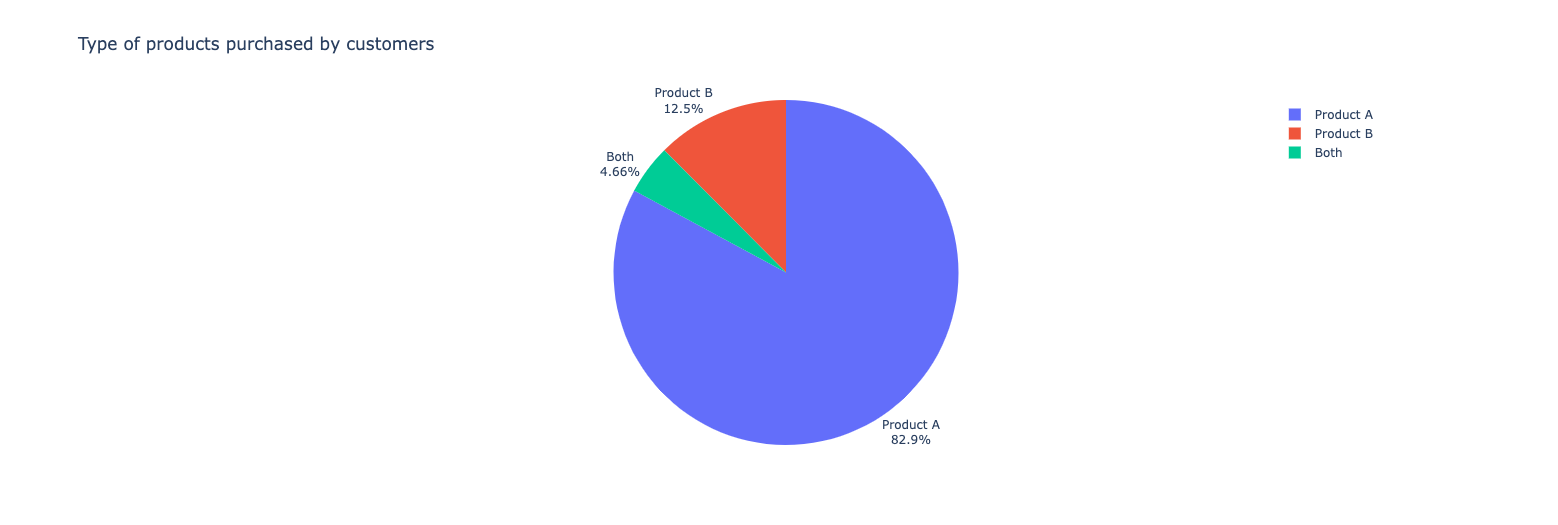

In addition, 95% of the dataset has Not A Number (`NaN`) values. The machine learning models cannot make predictions with missing values. To fix this, we have used K-Nearest Neighbour Imputer which replaces the `NaN` values with the closest predicted value by the algorithm. 

The following machine learning models would give the best performance -
Random Forest, XGBoost, Logistic Regression and SVM

### How would you use this model – how would it bring value to the business?

Currently this notebook is a prototype. However if this solution is to go live, it can be used to predict how likely a customer is to purchase a product within seconds instead of clients running sophisticated calculations or asking additional questions. Instead of using a single prediction, we can use an enssemble method of multiple algorithms to make more accurate predictions.

### In your chosen scenario on how to use to model, how would you set up an experiment to control the outcomes of the new process?

For example, the model can be made to run as a background task. The business can trigger the robot by putting a file in a specific file location and the system can read the file, deal with the `NaN` data. On a given timeframe the model can also be made to automatically train itself and if the predictions are accurate enough, then the old model can be overwritten by the new one.

# Further work

Overall this notebook explores the provided classification dataset by asking questions which help us understand it. Then we use machine learning on the data to predict if a customer is likely to buy Product B via a Cross-sell or not. Further research can be done on other `NaN` value replacement methods. Currently `KNNImputation` is used and it could possibly make the data "fake" and give wrong results.